In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import truncnorm
from scipy.special import erf
from mujoco_py import load_model_from_path

from monte_carlo.sample_models import get_ua_scale_sample, get_la_scale_sample
from monte_carlo.constants import UA_LENGTH_MEAN, UA_LENGTH_STD, LA_LENGTH_MEAN, LA_LENGTH_STD
from shared_utils.general import gen_models_folder_path

Based on *2012 ANTHROPOMETRIC SURVEY OF U.S. ARMY
PERSONNEL: METHODS AND SUMMARY STATISTICS*


### Lower arm length

##### Check that the distribution is Gaussian

See p. 117 (127 in the PDF)

In [3]:
length_quantiles_index = np.concatenate((np.arange(1, 4), 5*np.arange(1, 20), np.arange(97, 100)))
print(length_quantiles_index)

[ 1  2  3  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 97 98
 99]


In [4]:
length_quantiles = np.array([31., 31.4, 31.7, 32., 32.6, 33, 33.4, 33.7, 33.9, 34.2, 34.4, 34.6, 34.8, 35.1, 35.3, 35.6, 35.8, 36.1, 36.4, 36.7, 37.2, 37.9, 38.5, 38.9, 39.5])
assert length_quantiles.shape == length_quantiles_index.shape

In [5]:
# approximation with a gaussian
theo_quantiles = 1/2*(1+erf((length_quantiles - LA_LENGTH_MEAN)/(np.sqrt(2)*LA_LENGTH_STD)))

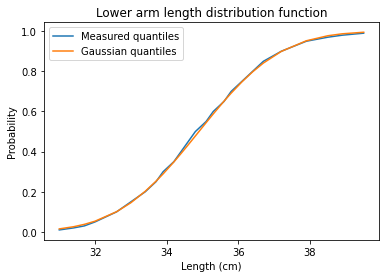

In [6]:
plt.plot(length_quantiles, length_quantiles_index/100., label="Measured quantiles")
plt.plot(length_quantiles, theo_quantiles, label="Gaussian quantiles")
plt.legend()
plt.xlabel("Length (cm)")
plt.ylabel("Probability")
plt.title("Lower arm length distribution function")
plt.show()

#### Check that model with scale == 1 is close from average

Measure lower arm length in the current model

In [7]:
model_path = os.path.join(gen_models_folder_path(), 'exo_with_patient', 'nesm_with_patient.xml')
assert os.path.isfile(model_path)
model = load_model_from_path(model_path)

In [8]:
fingers_idx = model.body_name2id("fingers_prox")
elbow_idx = model.body_name2id("ulna_r")

finger_elbow_delta = np.zeros(3)
floating_idx = fingers_idx
while(floating_idx != elbow_idx):
    finger_elbow_delta += model.body_pos[floating_idx]
    floating_idx = model.body_parentid[floating_idx]

In [9]:
print(f"Size of reference model: {np.linalg.norm(finger_elbow_delta)}")

Size of reference model: 0.36905689263310065


It is bigger than the average; however there is also a bias (tending to increase the length of the arm) in our simulation measurement.

We will assume that for la_s = 1, the length equals the mean.

#### Define scale sampler

Then we can define a random draw of scales; a truncated normal distribution is employed to prevent extreme values.

In [10]:
# It is assumed that the default model (ie with scale=1) is an average patient
la_mean = 1.
la_std = LA_LENGTH_STD / LA_LENGTH_MEAN
scale_ub = 1.1
scale_lb = .9

get_la_scale_sample(size=(20,))

array([0.96999072, 1.0019182 , 0.99268899, 1.00421575, 0.94773663,
       0.96650328, 1.00252796, 0.97497031, 0.94743697, 0.98426679,
       1.04616068, 0.9654693 , 0.98440143, 1.03336757, 1.06417801,
       0.99515424, 0.903978  , 0.98561125, 0.93989221, 0.98212422])

Here is a visualization of the truncated density function

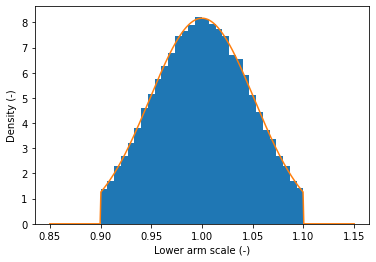

In [11]:
a, b = (scale_lb - la_mean)/la_std, (scale_ub - la_mean)/la_std
x_array = np.linspace(scale_lb-.05, scale_ub+.05, 400)


n_samples = (100000,)
plt.hist(get_la_scale_sample(n_samples), density=True, bins=30)
plt.plot(x_array, truncnorm.pdf(x_array, a, b, loc=la_mean, scale=la_std))
plt.xlabel("Lower arm scale (-)")
plt.ylabel("Density (-)")
plt.show()

### Upper arm

##### Check that the distribution is Gaussian

In [12]:
ua_length_quantiles = np.array([32.2, 32.7, 33., 33.4, 34., 34.5, 34.8, 35.2, 35.5, 35.7, 35.9, 36.1, 36.3, 36.5, 36.8, 37., 37.3, 37.6, 37.9, 38.3, 38.7, 39.4, 39.9, 40.2, 40.8])
assert ua_length_quantiles.shape == length_quantiles_index.shape

In [13]:
ua_mean = 36.37
ua_std = 1.82

ua_theo_length = 1/2*(1+erf((ua_length_quantiles - ua_mean)/(np.sqrt(2)*ua_std)))

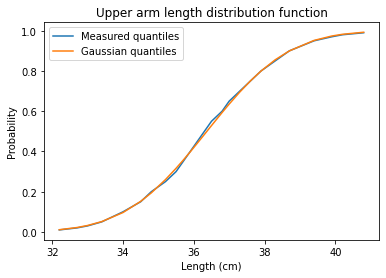

In [14]:
plt.plot(ua_length_quantiles, length_quantiles_index/100., label="Measured quantiles")
plt.plot(ua_length_quantiles, ua_theo_length, label="Gaussian quantiles")
plt.legend()
plt.xlabel("Length (cm)")
plt.ylabel("Probability")
plt.title("Upper arm length distribution function")
plt.show()

#### Check that model with scale == 1 is close from average

In [15]:
elbow_idx = model.body_name2id("ulna_r")

print(np.linalg.norm(model.body_pos[elbow_idx]))

0.29079914030134274


It is probably a bit small... but the distance here again is the pure distance between axis of rotation.

#### Define scale sampler

In [16]:
# It is assumed that the default model (ie with scale=1) is an average patient
ua_mean = 1.
ua_std = UA_LENGTH_STD / UA_LENGTH_MEAN
scale_ub = 1.1
scale_lb = .9

get_ua_scale_sample(size=(20,))

array([1.0018277 , 1.05617841, 1.01574359, 1.02797241, 0.93227175,
       0.95441036, 0.99342906, 1.09329822, 0.99290825, 0.94766745,
       1.0608845 , 0.93001477, 1.05748718, 1.09155379, 1.03032109,
       1.04607094, 1.01134689, 0.98416588, 0.9912557 , 0.9861024 ])

Here again we visualize the truncated distribution for the upper arm

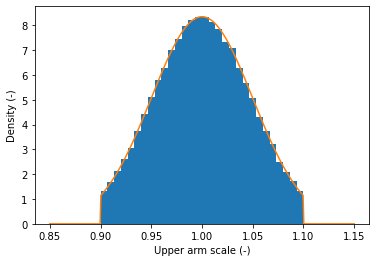

In [17]:
a, b = (scale_lb - ua_mean)/ua_std, (scale_ub - ua_mean)/ua_std
x_array = np.linspace(scale_lb-.05, scale_ub+.05, 400)

n_samples = (100000,)
plt.hist(get_ua_scale_sample(n_samples), density=True, bins=30)
plt.plot(x_array, truncnorm.pdf(x_array, a, b, loc=ua_mean, scale=ua_std))
plt.xlabel("Upper arm scale (-)")
plt.ylabel("Density (-)")
plt.show()